### Assignment Notes

 - identify which factors predict future user adoption
   - see data descriptions in next cell, two files
 - approx 1-2 hours, more or less fine
   - brief writeup of findings, concise is good
   - summary tables, graphs, code, queries that help understand approach
   - note factors considered, even if they weren't ultimately useful
   - identify further research or data that could be valuable

 - Contents
   - [Assignment](#Assignment-Notes)
   - [Data Description](#Data)
 - [Take Home Two](#Start)
   - [Part 1 - EDA](#EDA)
     - [explore](#Exploration)
     - [target definition: "adopted" user](#Target-Definition)
     - [cleaning and feature engineering](#Feature-Engineering-/-Cleaning)
     - [model based feature importance](#Model-based-Feature-Importance)
   - [Part 2 - Presentation](#Presentation)
     - [end of notebook](#end)

**Data**
 - `takehome_users`, (12000, 9), user_id index
|  **Feature**  | **Description** |
|--------------:|----------------:|
|  name | user's name |
|  object_id | user's id |
|  email | user's email |
|  creation_source | how account created, 5 options: `PERSONAL_PROJECTS, GUEST_INVITE, ORG_INVITE, SIGNUP, SIGNUP_GOOGLE_AUTH`    |
|  creation_time | account creation time |
|  last_session_creation_time | UNIX timestamp of last login |
|  opted_in_to_mailing_list | user receives mailing list |
|  enabled_for_marketing_drip | user receives marketing emails |
|  org_id | organization (group of users) user belongs to |
|  invited_by_user_id | id of inviting user, if applicable |

 - `takehome_user_engagement` (207917, 2), datetime index
   - row for each day a user logged into product
 - **Target Definition** `adopted`
   - an adopted user has logged into the product on three separate days in at least one seven-day period
   

# Start

In [1]:
# base packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from time import time
# sklearn dataprep and scoring
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, scale
from sklearn.model_selection import cross_validate
from sklearn.inspection import permutation_importance
# sklearn classifiers, note version 1.4 required
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
# other classifiers
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

## EDA

 - **users table `takehome_users.csv`** 
   - convert `creation_time`, `last_session_creation_time` to datetime
   - add login info in addition to adoption
 - **engagement table** AKA **logins `takehome_user_engagement.csv`**
   - convert index to datetime. *reports at most one login per user per day*
     - use to check for adoption: three separate days in any seven-day period
     - 8823 unique users in data, some users without any logins

In [223]:
users = pd.read_csv('takehome_users.csv', encoding_errors='replace', index_col=0)
users['creation_time'] = pd.to_datetime(users.creation_time)
users['last_session_creation_time'] = pd.to_datetime(users.last_session_creation_time*1e9)
# base_users = users.copy()
logins = pd.read_csv('takehome_user_engagement.csv', index_col=0)
logins.index = pd.to_datetime(logins.index)

# processed data
# users = pd.read_parquet('processed_users.parquet')

In [224]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   name                        12000 non-null  object        
 2   email                       12000 non-null  object        
 3   creation_source             12000 non-null  object        
 4   last_session_creation_time  8823 non-null   datetime64[ns]
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(3)
memory usage: 937.5+ KB


#### Exploration

In [129]:
users.sample(3)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
4445,2014-02-10 19:20:04,Dresner Kerstin,KerstinDresner@gmail.com,PERSONAL_PROJECTS,2014-05-11 19:20:04,0,0,121,NaN
2370,2013-03-23 18:42:41,Skene Archie,ArchieSkene@cuvox.de,ORG_INVITE,2013-05-07 18:42:41,0,0,20,7928.0
5892,2013-11-19 14:24:46,Nielsen Stine,StineMNielsen@gmail.com,SIGNUP_GOOGLE_AUTH,2014-06-02 14:24:46,0,0,78,NaN


In [25]:
logins.sample(3)

,user_id,visited
time_stamp,,
2013-10-19 14:23:02,3560,1
2013-10-14 20:14:20,11873,1
2013-11-28 23:06:34,1156,1


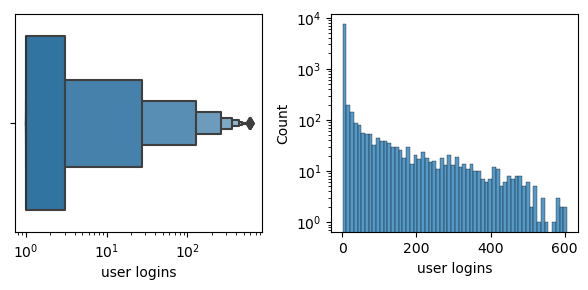

In [111]:
plt.figure(figsize=(6,3), tight_layout=True)
plt.subplot(121)
sns.boxenplot(x=logins.value_counts('user_id'))
plt.xscale('log')
plt.xlabel('user logins')
plt.subplot(122)
sns.histplot(logins.value_counts('user_id'), bins=60)
plt.yscale('log')
plt.xlabel('user logins')
plt.show()

In [89]:
logins.value_counts('user_id').sample(5)

user_id
5449      1
6046      1
10233    70
3970     23
7111     38
Name: count, dtype: int64

In [92]:
select_id = 3970

for tdelta in range(7):
    sub = logins[logins.user_id == select_id]
    agg = sub.resample('168h', origin = sub.index[0].date()+pd.Timedelta(f'{tdelta}days')).sum()[['visited']]
    print('timedelta:',tdelta, '| max: ', agg.max().values[0], '| min: ', agg.min().values[0], '| mean: ', round(agg.median().values[0],2))

timedelta: 0 | max:  4 | min:  0 | mean:  1.0
timedelta: 1 | max:  4 | min:  0 | mean:  1.0
timedelta: 2 | max:  4 | min:  0 | mean:  1.0
timedelta: 3 | max:  4 | min:  0 | mean:  1.0
timedelta: 4 | max:  3 | min:  0 | mean:  1.0
timedelta: 5 | max:  4 | min:  0 | mean:  1.0
timedelta: 6 | max:  4 | min:  0 | mean:  1.0


<Axes: ylabel='count'>

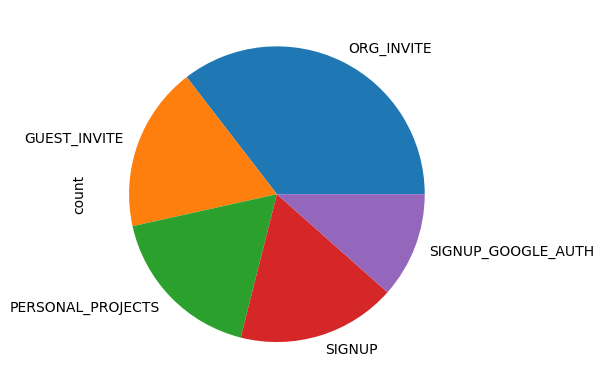

In [76]:
users.value_counts('creation_source').plot(kind='pie')

<Axes: xlabel='count'>

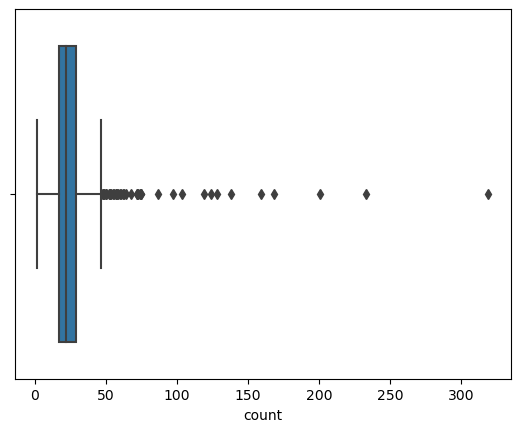

In [101]:
sns.boxplot(x=users.value_counts('org_id'))

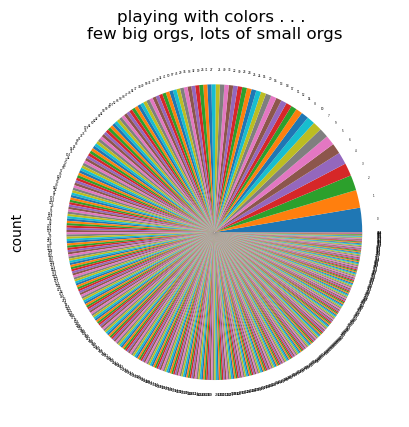

In [225]:
users.value_counts('org_id').plot(kind='pie', fontsize=2)
plt.title('playing with colors . . . \nfew big orgs, lots of small orgs')
plt.show()

#### Target Definition
 - add target, `adopted` boolean
 - "adopted user" logged into the product on 3 separate days over at least one-seven day period
   - provided usage summary is given in separate days, only need to check period counts
---
 - basic relationships
   - mailing list, marketing drip not very important
   - user invited by other user slightly more important than above
   - **creation_source variation**: google_auth, guest_invite relatively high adoption rate. personal_projects relatively low
   - no clear variation with account creation date (or day of week, or hour)
   - check organization below

In [226]:
users.sample(3)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
2854,2014-02-15 03:31:08,Baum Leonie,LeonieBaum@jourrapide.com,PERSONAL_PROJECTS,NaT,0,0,67,NaN
4814,2013-03-19 05:43:17,Rasmussen Mille,MilleFRasmussen@yahoo.com,ORG_INVITE,2013-03-20 05:43:17,0,0,14,850.0
3497,2014-03-13 17:29:15,Rocha Diego,DiegoBarbosaRocha@yahoo.com,GUEST_INVITE,2014-03-18 17:29:15,1,1,171,2139.0


In [227]:
%%time

for uid in tqdm(users.index):
    # check every row in "takehome_users"
    if type(users.loc[uid,'last_session_creation_time']) == type(pd.Timestamp(None)):
        # skip users without a single login
        users.loc[uid,'mean_usage'] = 0
        users.loc[uid,'total_usage'] = 0
        users.loc[uid,'adopted'] = False
        continue
    # count usage for each "7-day period"
    check_list = []
    use_list = []
    sub = logins[logins.user_id == uid]
    for tdelta in range(7): 
        # add "adopted" if any period >= 3
        # save other usage features
        agg = sub.resample('168h', origin = sub.index[0].date()+pd.Timedelta(f'{tdelta}days')).sum()[['visited']]
        check_list = agg.max().values[0]
        use_list = agg.mean().values[0]
    users.loc[uid,'mean_usage'] = 100*np.mean(use_list)
    users.loc[uid,'total_usage'] = sub.shape[0]
    users.loc[uid,'adopted'] = np.max(check_list) >= 3    

users['mean_usage'] = users['mean_usage'].astype(int)
users['total_usage'] = users['total_usage'].astype(int)
# users['invited_by_user_id'] = users['invited_by_user_id'].astype(int)

100%|██████████| 12000/12000 [02:09<00:00, 92.36it/s] 


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [228]:
users.sample(3)

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,mean_usage,total_usage,adopted
object_id,,,,,,,,,,,,
1949,2013-04-05 16:54:18,White Clyde,ClydeFWhite@yahoo.com,ORG_INVITE,2013-04-23 16:54:18,0,0,39,10887.0,66,2,False
8875,2012-09-14 04:23:06,Chaney Dale,DaleVChaney@gmail.com,SIGNUP_GOOGLE_AUTH,2012-09-15 04:23:06,0,0,4,NaN,100,1,False
9275,2014-01-26 03:40:37,G�rtner Laura,LauraGartner@yahoo.com,PERSONAL_PROJECTS,NaT,1,0,5,NaN,0,0,False


In [229]:
users.value_counts('adopted')

adopted
False    10538
True      1462
Name: count, dtype: int64

In [230]:
users.to_parquet('processed_users.parquet')

In [133]:
users.sample(5).T

object_id,5324,8413,1177,1252,4595
creation_time,2013-07-13 12:09:03,2013-02-21 12:22:01,2013-05-25 20:42:19,2012-08-30 19:34:00,2013-01-07 14:28:17
name,Huneycutt Charles,Sousa Manuela,Peters Harrison,Kohl Ursula,Webster Oscar
email,CharlesSHuneycutt@yahoo.com,ManuelaAzevedoSousa@jourrapide.com,ddcemwal@dhafc.com,UrsulaKohl@jourrapide.com,dhbhirot@cfqpe.com
creation_source,ORG_INVITE,GUEST_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP
last_session_creation_time,NaT,2013-02-21 12:22:01,2013-05-26 20:42:19,2012-09-01 19:34:00,2013-01-09 14:28:17
opted_in_to_mailing_list,0,1,0,0,0
enabled_for_marketing_drip,0,1,0,0,0
org_id,66,75,51,16,0
invited_by_user_id,9964.0,7510.0,NaN,NaN,NaN
mean_usage,0.0,1.0,1.0,1.0,1.0


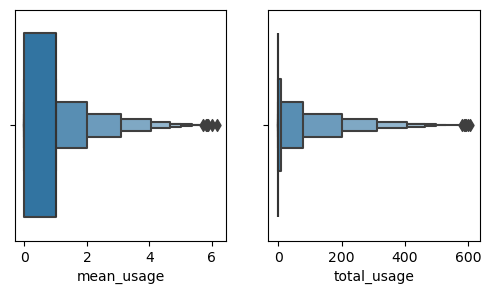

In [248]:
plt.figure(figsize=(6,3))
plt.subplot(121)
sns.boxenplot(x=users.mean_usage/100)
plt.subplot(122)
sns.boxenplot(x=users.total_usage)
plt.show()

In [130]:
def adoption_rate(df):
    return 100*df[df.adopted==True].shape[0]/df.shape[0]

In [204]:
print('invited by user relative to total adoption rates\n(no,yes)')
adoption_rate(users[users.invited_by_user_id.isna()])/adoption_rate(users),\
adoption_rate(users[~users.invited_by_user_id.isna()])/adoption_rate(users)

invited by user relative to total adoption rates
(no,yes)


(0.9320849667485304, 1.0590883014871364)

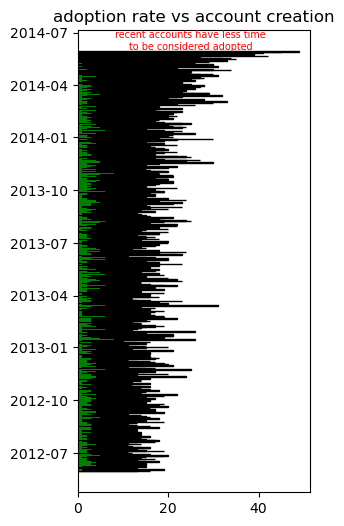

In [186]:
plt.figure(figsize=(3,6))
plt.hist(x = users.creation_time, orientation='horizontal',
         color='k', edgecolor='k', bins=np.sort(users.creation_time.dt.date.unique()))
plt.hist(x = users[users.adopted==True].creation_time, orientation='horizontal',
         color='g', edgecolor=None, bins=np.sort(users.creation_time.dt.date.unique()))
plt.title('adoption rate vs account creation')
plt.suptitle('recent accounts have less time\nto be considered adopted', y=0.88, fontsize='x-small', 
             ha='center', color='r')
plt.show()

In [271]:
# see creation_source, 
# see inviter_adopted with processed data
# add dt.<freq> for creation_time
f1 = 'inviter_adopted' 
f2 = 'adopted'

print('\tadoption rate relative to overall, 1 = avg\n')
print(f1)
for f1_v in users[f1].unique():
    if pd.isna(f1_v):
        sub = users[users[f1].isna()]
    else:
        sub = users[users[f1]==f1_v]
    print(f'{f1_v} [{sub.shape[0]}]', str(round((adoption_rate(sub)/adoption_rate(users)),2)).rjust(25-len(str(f1_v))))

	adoption rate relative to overall, 1 = avg

inviter_adopted
False [5395]                 0.98
True [1022]                  1.49
nan [5583]                   0.93


#### Feature Engineering / Cleaning
  - prepare data for modeling
    - make `creation_source` categorical, encode
    - shouldn't treat `org_id` as numerical feature when modeling
      - add users in org, org_usage
    - link `invited_by_user_id` to inviting user, indicate if the inviting user was adopted
      - ~~indicate if part of same org~~ they all are
      - add inviting user info

In [279]:
users = pd.read_parquet('processed_users.parquet')

In [280]:
users.sample(3).T

object_id,10327,4507,6502
creation_time,2013-05-24 08:53:36,2014-05-02 01:20:54,2014-05-28 02:58:21
name,Kuhn Julia,Furst Patrick,Nygaard Liv
email,JuliaKuhn@hotmail.com,PatrickFurst@gustr.com,LivDNygaard@gmail.com
creation_source,ORG_INVITE,ORG_INVITE,SIGNUP_GOOGLE_AUTH
last_session_creation_time,NaT,2014-05-03 01:20:54,2014-05-28 02:58:21
opted_in_to_mailing_list,0,1,0
enabled_for_marketing_drip,0,0,0
org_id,1,89,49
invited_by_user_id,1815.0,8272.0,NaN
mean_usage,0,100,100


In [284]:
%%time

# inviting user info
for uid in tqdm(users[users.invited_by_user_id>0].index):
    invite = users.loc[users.loc[uid,'invited_by_user_id']]
    users.loc[uid,'inviter_adopted'] = invite.adopted
    users.loc[uid,'inviter_usage'] = invite.mean_usage
    
    users.loc[uid,'inviter_invites'] = users[users.invited_by_user_id==invite.name].shape[0]
    users.loc[uid,'user_invites'] = users[users.invited_by_user_id==uid].shape[0]

# organization info
for org_id in tqdm(users.org_id.unique()):
    sub = users[users.org_id == org_id] 
    users.loc[sub.index, 'org_users'] = sub.shape[0]
    users.loc[sub.index, 'org_usage'] = np.mean(sub.mean_usage)
# dytpes
users['org_users'] = users['org_users'].astype(int)
users['org_usage'] = users['org_usage'].astype(int)
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)
users['invited_by_user_id'] = users['invited_by_user_id'].astype(int)

users['inviter_invites'] = users['inviter_invites'].fillna(0)
users['inviter_invites'] = users['inviter_invites'].astype(int)

users['user_invites'] = users['user_invites'].fillna(0)
users['user_invites'] = users['user_invites'].astype(int)

100%|██████████| 417/417 [00:00<00:00, 717.72it/s]

CPU times: total: 13.6 s
Wall time: 13.6 s


In [285]:
users.sample(5).T

object_id,8195,3448,8930,6798,6052
creation_time,2014-04-17 04:44:58,2013-01-11 13:18:21,2013-01-30 08:10:52,2012-11-03 05:47:44,2014-04-12 19:33:18
name,Binnie Summer,Steere Lara,Collins Willard,Fox John,Kj�r Marcus
email,SummerBinnie@jourrapide.com,LaraSteere@jourrapide.com,nzkyspwq@owqow.com,lcemzmkn@kkvxf.com,MarcusPKjaer@yahoo.com
creation_source,PERSONAL_PROJECTS,PERSONAL_PROJECTS,ORG_INVITE,SIGNUP,ORG_INVITE
last_session_creation_time,2014-04-20 04:44:58,NaT,NaT,NaT,2014-04-13 19:33:18
opted_in_to_mailing_list,0,1,0,1,0
enabled_for_marketing_drip,1,0,0,0,0
org_id,324,53,30,314,107
invited_by_user_id,0,0,4031,0,11734
mean_usage,100,0,0,0,100


---

In [286]:
users[users.adopted==True].sample(5).T

object_id,6851,7555,4105,1617,2002
creation_time,2012-06-27 20:52:35,2012-12-23 20:10:48,2013-05-27 10:29:21,2012-12-02 18:48:20,2013-07-09 12:57:19
name,Koehler Katharina,Webb Meghan,Bartlett Kyle,Santos Melissa,Cunha Melissa
email,KatharinaKoehler@gmail.com,MeghanEWebb@jourrapide.com,KyleBartlett@cuvox.de,MelissaCastroSantos@gmail.com,MelissaSousaCunha@cuvox.de
creation_source,SIGNUP,GUEST_INVITE,PERSONAL_PROJECTS,SIGNUP_GOOGLE_AUTH,ORG_INVITE
last_session_creation_time,2014-05-26 20:52:35,2013-09-08 20:10:48,2014-05-26 10:29:21,2014-06-03 18:48:20,2014-06-04 12:57:19
opted_in_to_mailing_list,1,0,0,0,0
enabled_for_marketing_drip,1,0,0,0,0
org_id,25,245,358,78,205
invited_by_user_id,0,2229,0,0,3316
mean_usage,166,231,471,384,202


In [287]:
users[(users.adopted==False) & (~users.last_session_creation_time.isna())].sample(5).T

object_id,11882,11069,8385,5277,7591
creation_time,2013-12-16 08:32:33,2013-09-01 12:11:08,2013-12-12 20:05:19,2014-01-27 20:58:36,2013-05-01 05:23:52
name,Alves Renan,Schmitz Andreas,Pownall Isabel,Burrows Maya,Furphy Maya
email,RenanCorreiaAlves@jourrapide.com,xjdojcku@uqrno.com,IsabelPownall@gmail.com,MayaBurrows@cuvox.de,MayaFurphy@jourrapide.com
creation_source,SIGNUP,PERSONAL_PROJECTS,SIGNUP_GOOGLE_AUTH,GUEST_INVITE,SIGNUP
last_session_creation_time,2014-01-08 08:32:33,2013-09-01 12:11:08,2013-12-13 20:05:19,2014-01-28 20:58:36,2013-05-02 05:23:52
opted_in_to_mailing_list,0,0,0,1,1
enabled_for_marketing_drip,0,0,0,0,1
org_id,303,170,17,0,363
invited_by_user_id,0,0,0,344,0
mean_usage,50,100,100,100,100


In [232]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 1 to 12000
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   name                        12000 non-null  object        
 2   email                       12000 non-null  object        
 3   creation_source             12000 non-null  object        
 4   last_session_creation_time  8823 non-null   datetime64[ns]
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          6417 non-null   float64       
 9   mean_usage                  12000 non-null  int32         
 10  total_usage                 12000 non-null  int32         
 11  adopted                     12000 non-null  object        


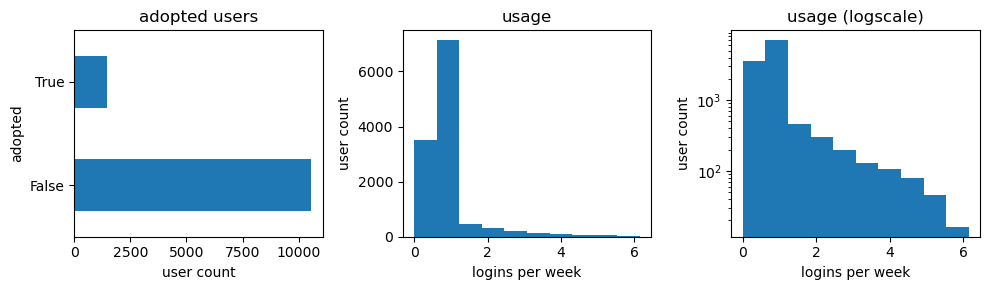

In [73]:
plt.figure(figsize=(10,3), tight_layout=True)
plt.subplot(131)
users.value_counts('adopted').plot(kind='barh')
plt.title('adopted users')
plt.xlabel('user count')

plt.subplot(132)
users.mean_usage.plot(kind='hist')
plt.xlabel('logins per week')
plt.ylabel('user count')
plt.title('usage')

plt.subplot(133)
users.mean_usage.plot(kind='hist')
plt.xlabel('logins per week')
plt.ylabel('user count')
plt.title('usage (logscale)')
plt.yscale('log')
plt.show()

- final steps 
  - convert invited_by_user_id to boolean
  - fill inviter_adopted `NaN` with False
  - fill inviter_usage `NaN` with 0, convert to int 
  - *sklearn*
    - encode creation_source and org_id
    - scale numerical values

In [291]:
users['invited_by_user_id'] = users['invited_by_user_id'] > 0
users['inviter_adopted'] = users['inviter_adopted'].fillna(False)
users['inviter_usage'] = users['inviter_usage'].fillna(0)
users['inviter_usage'] = users['inviter_usage'].astype(int)

In [ ]:
users = users.drop(columns=['creation_time','name','email','last_session_creation_time'])

In [ ]:
users['opted_in_to_mailing_list'] = users['opted_in_to_mailing_list'].astype(bool)
users['enabled_for_marketing_drip'] = users['enabled_for_marketing_drip'].astype(bool)

In [327]:
users.loc[users[users.org_id==0].index,'org_users'] = 0
users.loc[users[users.org_id==0].index,'org_usage'] = 0

In [293]:
users.to_parquet('pre_model_data.parquet')

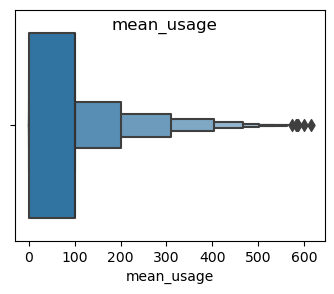

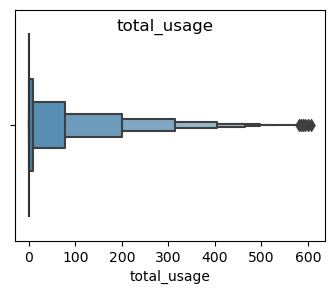

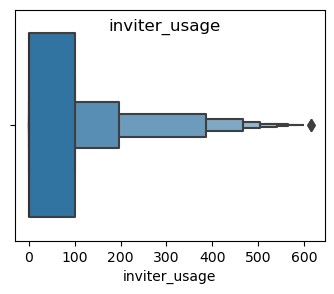

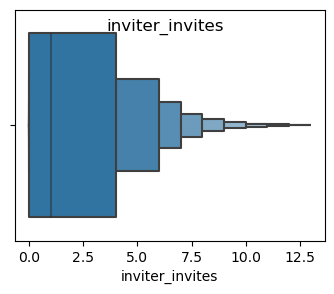

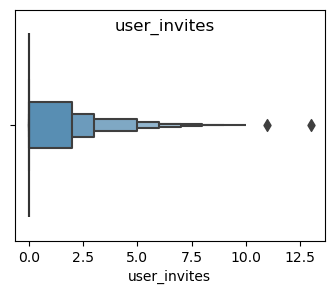

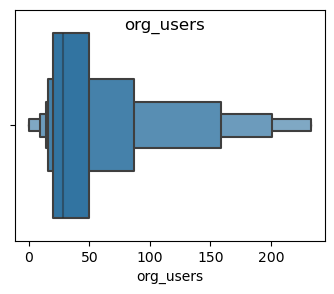

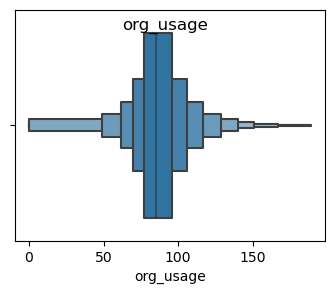

In [334]:
for f in ['mean_usage','total_usage','inviter_usage','inviter_invites','user_invites','org_users','org_usage']:
    plt.figure(figsize=(4,3))
    sns.boxenplot(x=users[f])
    #plt.xscale('log')
    plt.suptitle(f, y=0.85)
    plt.show()

#### Model-based Feature Importance
 - encode creation_source, org_id?
 - drop datetime, object columns
 - standardize numerical columns?
   - only org_usage is normal, some are half-norm

In [3]:
d = pd.read_parquet('pre_model_data.parquet')
cat_features = ['creation_source','org_id']
num_features = ['mean_usage','total_usage','inviter_usage','inviter_invites','user_invites','org_users','org_usage']

scaler = StandardScaler()
d[num_features] = scaler.fit_transform(d[num_features])

enc = OrdinalEncoder()
d[cat_features] = enc.fit_transform(d[cat_features])
d[cat_features] = d[cat_features].astype(int)
d[cat_features] = d[cat_features].astype('category')

In [364]:
d.sample(6).T

object_id,8010,3339,5872,8696,2173,7600
creation_source,2,2,3,4,2,3
opted_in_to_mailing_list,False,False,True,False,False,True
enabled_for_marketing_drip,False,False,False,False,False,False
org_id,76,123,103,7,35,210
invited_by_user_id,False,False,False,False,False,False
mean_usage,2.798722,3.866997,0.140177,0.140177,-1.073771,3.393557
total_usage,3.059393,4.101624,-0.253969,-0.253969,-0.269524,4.832742
adopted,True,True,False,False,False,True
inviter_adopted,False,False,False,False,False,False
inviter_usage,-0.567427,-0.567427,-0.567427,-0.567427,-0.567427,-0.567427


In [105]:
models = [LogisticRegression(max_iter=500),  ExtraTreesClassifier(), 
          HistGradientBoostingClassifier(), LGBMClassifier(cat_features=cat_features), 
          CatBoostClassifier(cat_features=cat_features), XGBClassifier(enable_categorical=True),
          KNeighborsClassifier(),]

# models = [LogisticRegression(max_iter=500),]

In [106]:
%%time

table = pd.DataFrame()
pbar = tqdm(models)

for m in pbar:
    m_name = m.__class__.__name__
    pbar.set_description(m_name)
    # cv scores
    start = time()
    cv = cross_validate(m, d.drop(columns='adopted'), d['adopted'],
                    scoring=['balanced_accuracy', 'f1', 'roc_auc'],  n_jobs=-1)
    
    table.loc[m_name, 'cv_time'] = round(time()-start)
    table.loc[m_name, 'bal_acc'] = np.mean(cv['test_balanced_accuracy'])
    table.loc[m_name, 'f1'] = np.mean(cv['test_f1'])
    table.loc[m_name, 'roc_auc'] = np.mean(cv['test_roc_auc'])
    
    # model feature importance
    start = time()
    m.fit(d.drop(columns='adopted'), d['adopted'],)
    if m_name == 'LGBMClassifier':
        table.loc[m_name, m.feature_name_] = m.feature_importances_/m.feature_importances_.max()
        table.loc[m_name,'feature_time'] = round(time()-start)
    
    elif m_name == 'CatBoostClassifier':
        table.loc[m_name, m.feature_names_] = m.get_feature_importance()/m.get_feature_importance().max()
        table.loc[m_name,'feature_time'] = round(time()-start)
        
    elif m_name == 'XGBClassifier':
        table.loc[m_name, m.feature_names_in_] = m.feature_importances_/m.feature_importances_.max()
        table.loc[m_name,'feature_time'] = round(time()-start)
    else:
        mod_fi = permutation_importance(m, d.drop(columns='adopted'), d['adopted'],)
        table.loc[m_name,'feature_time'] = round(time()-start)
        table.loc[m_name, m.feature_names_in_] = mod_fi['importances_mean']/np.max(mod_fi['importances_mean'])
        
table.to_csv('model_scores_feature_imp.csv')

CatBoostClassifier:  57%|████████████████████████████████████▌                           | 4/7 [00:17<00:11,  3.78s/it]

[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] Unknown parameter: cat_features
[LightGBM] [Info] Number of positive: 1462, number of negative: 10538
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1324
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121833 -> initscore=-1.975182
[LightGBM] [Info] Start training from score -1.975182
Learning rate set to 0.029768
0:	learn: 0.6316639	total: 17.6ms	remaining: 17.6s
1:	learn: 0.5708761	total: 52.6ms	remaining: 26.2s
2:	learn: 0.5229091	total: 76.6ms	rema

CatBoostClassifier:  71%|█████████████████████████████████████████████▋                  | 5/7 [01:43<01:06, 33.46s/it]

996:	learn: 0.0084439	total: 41.6s	remaining: 125ms
997:	learn: 0.0084439	total: 41.7s	remaining: 83.5ms
998:	learn: 0.0084374	total: 41.7s	remaining: 41.7ms
999:	learn: 0.0084195	total: 41.7s	remaining: 0us


KNeighborsClassifier: 100%|██████████████████████████████████████████████████████████████| 7/7 [02:39<00:00, 22.85s/it]

CPU times: total: 5min
Wall time: 2min 39s


In [121]:
table.to_csv('model_scores_feature_imp.csv')

## Presentation
*see images, code to generate tables in cells below*

In [64]:
d.adopted.sum()/d.shape[0]

0.12183333333333334

 - **Task: Which factors predict future user adoption?**
 - **Background:**
   - usage summary table used to determine whether a user was adopted: `Overall adoption rate: 12.2%`
     - most recently created users have less time to be considered adopted
     - information about inviting user and organization added for each applicable user
   - featured individual explored, relationships to adoption studied
     - adoption rate at various feature values compared to overall adoption rate
   - data prepared for modeling
     - categorical columns ordinally encoded
     - numerical columns z-scale normalized
     - remaining string and datetime columns dropped
   - feature importance explored via correlation coefficient
   - feature importance explored via model importance. baseline parameters used for each model
     - `sklearn` model importance determined via permutation feature importance
     - `XGBoost`, `CatBoost`, `LGBM` model importance determined via model attributes
     - quick/dirty model training, evaluated via 5-fold cross-validation and fit to entire dataset to determine feature importance
       - classification metrics similar for most models, pretty good scores
         - kNN model did not show good performance
     - variety of models provides good composite of feature importance for predicting adoption
 - **Answer:**
   - In general the following factors are listed from more to less predictive of user adoption:
     - organization to which they join and its number of users, if applicable
     - whether a user opted into the mailing list, their sent invites, and how they created they account
     - whether a user was invited by another user or enabled the marketing drip
       - whether the inviting user was "adopted" or not was fairly predictive
   - "Usage" features are the most predictive of user adoption, but are directly related. I.E. **adoption** criterium is based on **usage**
     - total usage (days logged in) more predictive than mean usage (avg days logged in per week)
 - **Maybe Later:**
   - name and email could be considered. simply using the domain name of the email address may be helpful
   - more features to extract from usage, organization info
   - make multi-class classification. more detailed usage based definition
     - adopted user, as defined
     - inactive user, a user who has logged in at least once more than their account creation time but is not adopted
     - pristine user, a user who has never logged in or only logged when their account was created

![classification scores](./table_images/scores.png)

![model feature importance](./table_images/no_usage_features.png)

---
*all features included, usage directly relates to target*

![model feature importance](./table_images/all_features.png)

---

In [4]:
d = pd.read_parquet('pre_model_data.parquet')
cat_features = ['creation_source','org_id']
num_features = ['mean_usage','total_usage','inviter_usage','inviter_invites','user_invites','org_users','org_usage']

scaler = StandardScaler()
d[num_features] = scaler.fit_transform(d[num_features])

enc = OrdinalEncoder()
d[cat_features] = enc.fit_transform(d[cat_features])
d[cat_features] = d[cat_features].astype(int)
d[cat_features] = d[cat_features].astype('category')

In [5]:
table = pd.read_csv('model_scores_feature_imp.csv', index_col=0)
corr_scores = d.corr().loc[:,'adopted'].drop(index='adopted', columns=cat_features)**2
corr_scores = corr_scores/corr_scores.max()
table.loc['R2', corr_scores.index] = corr_scores.values
table.rename(columns={'invited_by_user_id':'invited'}, inplace=True)
table.T

,LogisticRegression,ExtraTreesClassifier,HistGradientBoostingClassifier,LGBMClassifier,CatBoostClassifier,XGBClassifier,KNeighborsClassifier,R2
cv_time,0.000000,1.000000,1.000000,2.000000,44.000000,0.000000,0.000000,NaN
bal_acc,0.941880,0.947870,0.964580,0.964757,NaN,0.964531,0.699318,NaN
f1,0.934268,0.933876,0.941859,0.946990,NaN,0.941508,0.567506,NaN
roc_auc,0.997785,0.997906,0.998492,0.998560,0.998617,0.998303,0.814451,NaN
feature_time,1.000000,11.000000,2.000000,0.000000,42.000000,0.000000,56.000000,NaN
creation_source,-0.001796,0.020390,0.004178,0.010767,0.201973,0.012544,0.013484,0.000009
opted_in_to_mailing_list,-0.000337,0.013409,0.002867,0.088829,0.087453,0.018242,0.000941,0.000064
enabled_for_marketing_drip,-0.000786,0.008311,0.000492,0.032301,0.021011,0.010820,0.005644,0.000049
org_id,-0.000337,0.021277,0.021055,0.138627,0.314735,0.010298,0.123236,0.008837
invited,-0.000673,0.000332,-0.000410,0.040377,0.005126,0.023285,-0.003136,0.001209


In [34]:
table.style\
     .background_gradient(cmap='bone',  subset=['cv_time','feature_time'])\
     .background_gradient(cmap='PiYG', subset=['bal_acc','f1','roc_auc'])\
     .background_gradient(cmap='Blues', subset=table.columns[5:], axis=1)\
     .format(formatter="{:.3f}", subset=table.columns[:5])\
     .format(formatter="{:.2e}", subset=table.columns[5:])#.to_html('table1.html')

,cv_time,bal_acc,f1,roc_auc,feature_time,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,mean_usage,total_usage,inviter_adopted,inviter_usage,inviter_invites,user_invites,org_users,org_usage
LogisticRegression,0.000,0.942,0.934,0.998,1.000,-1.80e-03,-3.37e-04,-7.86e-04,-3.37e-04,-6.73e-04,2.78e-01,1.00e+00,-3.37e-04,-5.61e-04,-6.73e-04,0.00e+00,-3.37e-04,-8.98e-04
ExtraTreesClassifier,1.000,0.948,0.934,0.998,11.000,2.04e-02,1.34e-02,8.31e-03,2.13e-02,3.32e-04,3.56e-01,1.00e+00,7.20e-03,3.44e-03,2.77e-03,4.43e-03,9.20e-03,8.75e-03
HistGradientBoostingClassifier,1.000,0.965,0.942,0.998,2.000,4.18e-03,2.87e-03,4.92e-04,2.11e-02,-4.10e-04,6.77e-02,1.00e+00,1.64e-04,8.27e-03,6.64e-03,2.38e-03,1.24e-02,2.10e-02
LGBMClassifier,2.000,0.965,0.947,0.999,0.000,1.08e-02,8.88e-02,3.23e-02,1.39e-01,4.04e-02,1.00e+00,8.47e-01,1.35e-02,2.26e-01,2.57e-01,6.73e-02,6.76e-01,6.41e-01
CatBoostClassifier,44.000,nan,nan,0.999,42.000,2.02e-01,8.75e-02,2.10e-02,3.15e-01,5.13e-03,3.73e-01,1.00e+00,9.10e-03,8.19e-02,5.53e-02,3.54e-02,1.82e-01,2.36e-01
XGBClassifier,0.000,0.965,0.942,0.998,0.000,1.25e-02,1.82e-02,1.08e-02,1.03e-02,2.33e-02,2.77e-02,1.00e+00,1.01e-02,1.23e-02,1.13e-02,1.18e-02,1.13e-02,1.06e-02
KNeighborsClassifier,0.000,0.699,0.568,0.814,56.000,1.35e-02,9.41e-04,5.64e-03,1.23e-01,-3.14e-03,7.67e-01,1.00e+00,-6.59e-03,-7.53e-03,-8.15e-03,-1.25e-03,5.64e-03,-4.39e-03
R2,nan,nan,nan,nan,nan,9.47e-06,6.41e-05,4.94e-05,8.84e-03,1.21e-03,9.43e-01,1.00e+00,6.62e-03,5.06e-03,2.36e-04,5.64e-03,7.15e-03,4.47e-02


In [40]:
no_use = table.copy()
no_use.drop(columns=['mean_usage','total_usage', 'org_usage', 'inviter_usage'], inplace=True)

for m in no_use.index:
    if m == 'LogisticRegression':
        no_use.loc[m,no_use.columns[5:]] = no_use.loc[m,no_use.columns[5:]]-np.min(no_use.loc[m,no_use.columns[5:]])
    else:
        no_use.loc[m,no_use.columns[5:]] = no_use.loc[m,no_use.columns[5:]]+np.min(no_use.loc[m,no_use.columns[5:]])
    no_use.loc[m,no_use.columns[5:]] = no_use.loc[m,no_use.columns[5:]]/np.max(no_use.loc[m,no_use.columns[5:]])

no_use.style\
     .background_gradient(cmap='bone',  subset=['cv_time','feature_time'])\
     .background_gradient(cmap='PiYG', subset=['bal_acc','f1','roc_auc'])\
     .background_gradient(cmap='Blues', subset=no_use.columns[5:], axis=1)\
     .format(formatter="{:.3f}", subset=no_use.columns[:5])\
     .format(formatter="{:.2e}", subset=no_use.columns[5:])#.to_html('table2.html')

,cv_time,bal_acc,f1,roc_auc,feature_time,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,inviter_adopted,inviter_invites,user_invites,org_users
LogisticRegression,0.000,0.942,0.934,0.998,1.000,0.00e+00,8.12e-01,5.62e-01,8.12e-01,6.25e-01,8.12e-01,6.25e-01,1.00e+00,8.12e-01
ExtraTreesClassifier,1.000,0.948,0.934,0.998,11.000,9.59e-01,6.36e-01,4.00e-01,1.00e+00,3.08e-02,3.49e-01,1.44e-01,2.21e-01,4.41e-01
HistGradientBoostingClassifier,1.000,0.965,0.942,0.998,2.000,1.83e-01,1.19e-01,3.97e-03,1.00e+00,-3.97e-02,-1.19e-02,3.02e-01,9.52e-02,5.79e-01
LGBMClassifier,2.000,0.965,0.947,0.999,0.000,3.14e-02,1.45e-01,6.27e-02,2.18e-01,7.45e-02,3.53e-02,3.90e-01,1.14e-01,1.00e+00
CatBoostClassifier,44.000,nan,nan,0.999,42.000,6.47e-01,2.89e-01,8.17e-02,1.00e+00,3.20e-02,4.45e-02,1.89e-01,1.27e-01,5.86e-01
XGBClassifier,0.000,0.965,0.942,0.998,0.000,6.78e-01,8.49e-01,6.27e-01,6.11e-01,1.00e+00,6.05e-01,6.40e-01,6.57e-01,6.42e-01
KNeighborsClassifier,0.000,0.699,0.568,0.814,56.000,4.63e-02,-6.27e-02,-2.18e-02,1.00e+00,-9.81e-02,-1.28e-01,-1.42e-01,-8.17e-02,-2.18e-02
R2,nan,nan,nan,nan,nan,2.14e-03,8.32e-03,6.66e-03,1.00e+00,1.38e-01,7.49e-01,2.77e-02,6.39e-01,8.09e-01


In [30]:
table.iloc[:,:5].style\
     .background_gradient(cmap='bone',  subset=['cv_time','feature_time'])\
     .background_gradient(cmap='PiYG', subset=['bal_acc','f1','roc_auc'])\
     .format(formatter="{:.0f}", subset=['cv_time','feature_time'])\
     .format(formatter="{:.3f}", subset=table.columns[1:4])#.to_html('model_scores.html')

,cv_time,bal_acc,f1,roc_auc,feature_time
LogisticRegression,0,0.942,0.934,0.998,1
ExtraTreesClassifier,1,0.948,0.934,0.998,11
HistGradientBoostingClassifier,1,0.965,0.942,0.998,2
LGBMClassifier,2,0.965,0.947,0.999,0
CatBoostClassifier,44,nan,nan,0.999,42
XGBClassifier,0,0.965,0.942,0.998,0
KNeighborsClassifier,0,0.699,0.568,0.814,56
R2,nan,nan,nan,nan,nan


In [31]:
table.iloc[:,5:].style\
     .background_gradient(cmap='Blues', subset=table.columns[5:], axis=1)\
     .format(formatter="{:.2e}", subset=table.columns[5:])#.to_html('feature_imp_1.html')

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,mean_usage,total_usage,inviter_adopted,inviter_usage,inviter_invites,user_invites,org_users,org_usage
LogisticRegression,-1.80e-03,-3.37e-04,-7.86e-04,-3.37e-04,-6.73e-04,2.78e-01,1.00e+00,-3.37e-04,-5.61e-04,-6.73e-04,0.00e+00,-3.37e-04,-8.98e-04
ExtraTreesClassifier,2.04e-02,1.34e-02,8.31e-03,2.13e-02,3.32e-04,3.56e-01,1.00e+00,7.20e-03,3.44e-03,2.77e-03,4.43e-03,9.20e-03,8.75e-03
HistGradientBoostingClassifier,4.18e-03,2.87e-03,4.92e-04,2.11e-02,-4.10e-04,6.77e-02,1.00e+00,1.64e-04,8.27e-03,6.64e-03,2.38e-03,1.24e-02,2.10e-02
LGBMClassifier,1.08e-02,8.88e-02,3.23e-02,1.39e-01,4.04e-02,1.00e+00,8.47e-01,1.35e-02,2.26e-01,2.57e-01,6.73e-02,6.76e-01,6.41e-01
CatBoostClassifier,2.02e-01,8.75e-02,2.10e-02,3.15e-01,5.13e-03,3.73e-01,1.00e+00,9.10e-03,8.19e-02,5.53e-02,3.54e-02,1.82e-01,2.36e-01
XGBClassifier,1.25e-02,1.82e-02,1.08e-02,1.03e-02,2.33e-02,2.77e-02,1.00e+00,1.01e-02,1.23e-02,1.13e-02,1.18e-02,1.13e-02,1.06e-02
KNeighborsClassifier,1.35e-02,9.41e-04,5.64e-03,1.23e-01,-3.14e-03,7.67e-01,1.00e+00,-6.59e-03,-7.53e-03,-8.15e-03,-1.25e-03,5.64e-03,-4.39e-03
R2,9.47e-06,6.41e-05,4.94e-05,8.84e-03,1.21e-03,9.43e-01,1.00e+00,6.62e-03,5.06e-03,2.36e-04,5.64e-03,7.15e-03,4.47e-02


In [41]:
no_use.iloc[:,5:].style\
     .background_gradient(cmap='Blues', subset=no_use.columns[5:], axis=1)\
     .format(formatter="{:.2e}", subset=no_use.columns[5:])#.to_html('feature_imp_2.html')

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,inviter_adopted,inviter_invites,user_invites,org_users
LogisticRegression,0.00e+00,8.12e-01,5.62e-01,8.12e-01,6.25e-01,8.12e-01,6.25e-01,1.00e+00,8.12e-01
ExtraTreesClassifier,9.59e-01,6.36e-01,4.00e-01,1.00e+00,3.08e-02,3.49e-01,1.44e-01,2.21e-01,4.41e-01
HistGradientBoostingClassifier,1.83e-01,1.19e-01,3.97e-03,1.00e+00,-3.97e-02,-1.19e-02,3.02e-01,9.52e-02,5.79e-01
LGBMClassifier,3.14e-02,1.45e-01,6.27e-02,2.18e-01,7.45e-02,3.53e-02,3.90e-01,1.14e-01,1.00e+00
CatBoostClassifier,6.47e-01,2.89e-01,8.17e-02,1.00e+00,3.20e-02,4.45e-02,1.89e-01,1.27e-01,5.86e-01
XGBClassifier,6.78e-01,8.49e-01,6.27e-01,6.11e-01,1.00e+00,6.05e-01,6.40e-01,6.57e-01,6.42e-01
KNeighborsClassifier,4.63e-02,-6.27e-02,-2.18e-02,1.00e+00,-9.81e-02,-1.28e-01,-1.42e-01,-8.17e-02,-2.18e-02
R2,2.14e-03,8.32e-03,6.66e-03,1.00e+00,1.38e-01,7.49e-01,2.77e-02,6.39e-01,8.09e-01


In [52]:
summary.sum(axis=1)

LogisticRegression                6.062500
ExtraTreesClassifier              4.179487
HistGradientBoostingClassifier    2.230159
LGBMClassifier                    2.070588
CatBoostClassifier                2.996953
XGBClassifier                     6.310101
KNeighborsClassifier              0.490463
R2                                3.380088
dtype: float64

In [54]:
summary = no_use.iloc[:,5:]
t = summary.sum()
summary.loc['TOTAL',:] = t.values

C:\Users\Nish\AppData\Local\Temp\ipykernel_11968\3721071547.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary.loc['TOTAL',:] = t.values


In [65]:
summary.style\
     .background_gradient(cmap='Blues', axis=1)\
     .format(formatter="{:.2f}")#.to_html('feature_imp_2.html')

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited,inviter_adopted,inviter_invites,user_invites,org_users
LogisticRegression,0.00,0.81,0.56,0.81,0.62,0.81,0.62,1.00,0.81
ExtraTreesClassifier,0.96,0.64,0.40,1.00,0.03,0.35,0.14,0.22,0.44
HistGradientBoostingClassifier,0.18,0.12,0.00,1.00,-0.04,-0.01,0.30,0.10,0.58
LGBMClassifier,0.03,0.15,0.06,0.22,0.07,0.04,0.39,0.11,1.00
CatBoostClassifier,0.65,0.29,0.08,1.00,0.03,0.04,0.19,0.13,0.59
XGBClassifier,0.68,0.85,0.63,0.61,1.00,0.61,0.64,0.66,0.64
KNeighborsClassifier,0.05,-0.06,-0.02,1.00,-0.10,-0.13,-0.14,-0.08,-0.02
R2,0.00,0.01,0.01,1.00,0.14,0.75,0.03,0.64,0.81
TOTAL,2.55,2.80,1.72,6.64,1.76,2.46,2.18,2.77,4.85


---
#### end